In [5]:
from fbprophet import Prophet

In [2]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
from matplotlib  import rcParams

import warnings
warnings.filterwarnings("ignore")
 

In [3]:
%matplotlib inline
rcParams["figure.figsize"] = 16,6
c = '#386B7F'


In [4]:
# upload the data sets
store_data = pd.read_csv("store.csv")
sample_submission_data = pd.read_csv("test.csv")
test_data = pd.read_csv("test.csv")
train_data =pd.read_csv("train.csv",parse_dates = True)


# Task 1

#### Glance the data

In [4]:
#glance the data
print("shape of the  store data: ",store_data.shape)
print("\n")
print(store_data.info())
store_data.head()

shape of the  store data:  (1115, 10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB
None


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
print("shape of the  train data: ",train_data.shape)
print("\n")
print(train_data.nunique())
train_data.head()
train_data['Date']
train_data.dtypes

shape of the  train data:  (1017209, 9)


Store             1115
DayOfWeek            7
Date               942
Sales            21734
Customers         4086
Open                 2
Promo                2
StateHoliday         5
SchoolHoliday        2
dtype: int64


Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

In [6]:
print("shape of the  test data: ",test_data.shape)
print("\n")
print(test_data.nunique())
test_data.head()

shape of the  test data:  (41088, 8)


Id               41088
Store              856
DayOfWeek            7
Date                48
Open                 2
Promo                2
StateHoliday         2
SchoolHoliday        2
dtype: int64


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


Short description:
- **Sales**: the turnover for any given day (target variable).
- **Customers**: the number of customers on a given day.
- Open: an indicator for whether the store was open: 0 = closed, 1 = open.
- Promo: indicates whether a store is running a promo on that day.
- StateHoliday: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays.
- SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools.

- Store: a unique Id for each store
- StoreType: differentiates between 4 different store models: a, b, c, d
- Assortment: describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance: distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year]: gives the approximate year and month of the time the nearest competitor was opened
- Promo2: Promo2 is a continuing a promotion for some -stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week]: describes the year and calendar week when the store started participating in Promo2
- PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

### Data cleaning

In [7]:
#data extraction
train_data['Date'] = pd.to_datetime(train_data['Date'])
train_data['Year'] = train_data['Date'].dt.year
train_data['Month'] = train_data['Date'].dt.month
train_data['Day'] = train_data['Date'].dt.day
train_data['WeekOfYear'] = train_data['Date'].dt.weekofyear

# adding new variable
train_data['SalePerCustomer'] = train_data['Sales']/train_data['Customers']
train_data['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

In [8]:
train_d = train_data #for later

missing_data = pd.DataFrame(train_data.isna().sum(),columns=(['Missing Train']))
missing_data["missing_test"] = test_data.isnull().sum() # before deling missing values
missing_data

,Missing Train,missing_test
Store,0,0.0
DayOfWeek,0,0.0
Date,0,0.0
Sales,0,NaN
Customers,0,NaN
Open,0,11.0
Promo,0,0.0
StateHoliday,0,0.0
SchoolHoliday,0,0.0
Year,0,NaN


- as shown in the table the train data has no a missing value and the test data has a missing value for open variable , we impute it.

In [9]:
# impute the missing value in test data
test_data['Open'].fillna(test_data['Open'].mode, inplace = True)
test_data.isnull().values.any()


False

In [10]:
# closed stores
train_data[(train_data.Open == 0) & (train_data.Sales == 0)].count()

Store              172817
DayOfWeek          172817
Date               172817
Sales              172817
Customers          172817
Open               172817
Promo              172817
StateHoliday       172817
SchoolHoliday      172817
Year               172817
Month              172817
Day                172817
WeekOfYear         172817
SalePerCustomer         0
dtype: int64

- There're 172817 closed stores in the data. It is about 10% of the total amount of observations. To avoid any biased forecasts we will drop these values.

In [11]:
 
print(train_data.shape)
closed_stores = train_data[(train_data['Open'] == 0) & (train_data['Sales'] == 0)].index
train_data.drop(closed_stores,inplace = True)
print(train_data.shape)


(1017209, 14)
(844392, 14)


In [12]:
open_no_sale = train_data[(train_data["Open"] != 0) & (train_data['Sales'] == 0)].index
train_data[(train_data["Open"] != 0) & (train_data['Sales'] == 0)]['Date'].nunique()
  


49

- There are opened store with no sales on working days. There're only 49 days in the data, so we can assume that there were external factors involved,

In [13]:
train_data.drop(open_no_sale,inplace = True)
train_data.shape

(844338, 14)

In [14]:
#exceptional stores that has open during holidays

store_exc = train_data[(train_data["StateHoliday"] != "o") 
        & (train_data["Sales"] != 0)]["Store"].nunique()
print("exceptional stores that has opened during state holidays:",store_exc)


exceptional stores that has opened during state holidays: 1115


In [15]:
store_data.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

- We have few variables with missing values that we need to deal with. Let's start with the CompetitionDistance.

In [16]:
# missing values in CompetitionDistance
store_data[pd.isnull(store_data.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


- No particular pattern observed. In this case, it makes a complete sense to replace NaN with the median values (which is twice less that the average)

In [17]:
# fill NaN with a median value (skewed distribuion)
store_data['CompetitionDistance'].fillna(store_data['CompetitionDistance'].median(), inplace = True)

In [18]:
# replace NA's by 0
store_data.fillna(0, inplace = True)


In [19]:
print("Joining train set with an additional store information.")

train_store = pd.merge(train_data, store_data, how = 'inner', on = 'Store')

print("In total: ", train_store.shape)
train_store.head()

Joining train set with an additional store information.
In total:  (844338, 23)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,2015,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,2015,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,2015,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,2015,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


- In this section we will closely look at different levels of StoreType and how the main metric Sales is distributed among them.

In [20]:
train_store.groupby('StoreType')['Sales'].describe()


,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


- StoreType B has the highest average of Sales among all others, however we have much less data for it. So let's print an overall sum of Sales and Customers to see which StoreType is the most selling and crowded one:

In [21]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum()


,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


- Clearly stores of type A. StoreType D goes on the second place in both Sales and Customers. What about date periods? Seaborn's facet grid is the best tool for this task:

## Overview

####  Check for seasonality in training data set?

In [22]:
#check seasonality for the give store
def seasonality(store):
    sale = train_data[train_data.Store == store]
    sale = sale.sort_values(by = "Date",ascending= False)
    sns.lineplot(x = sale["Date"], y = sale["Sales"], color= c )

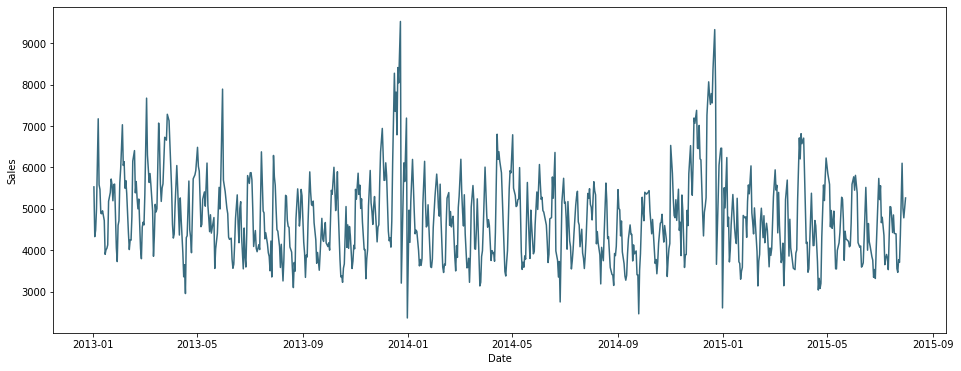

In [23]:
seasonality(1)

NB:
- christmass = around the last month(12-26)
- easter = around the the fourth month(04-06)
- public holiday = around the sixth month(06-04)

The slales around the holidays are  high 

####  Check & compare sales behavior before, during and after holidays 

In [24]:
pre_holiday = train_data[(train_data["Date"]> '2013-12-09') & (train_data["Date"]< '2013-12-20')  ]

during_holiday=train_data[(train_data["Date"]> '2013-12-22') & (train_data["Date"]< '2013-12-29')  ]

post_holiday = train_data[(train_data["Date"]> '2014-01-01') & (train_data["Date"]< '2014-01-15')  ]

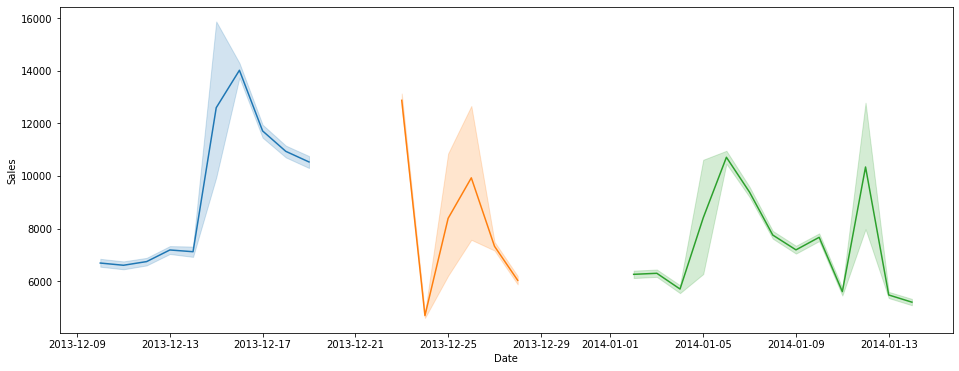

In [25]:
sns.lineplot(x = pre_holiday["Date"] , y = pre_holiday["Sales"] )
sns.lineplot(x = during_holiday["Date"] , y = during_holiday.Sales )
sns.lineplot(x = post_holiday["Date"] , y = post_holiday.Sales )

#### Find out any seasonal (Christmas, Easter etc) purchase behaviours,


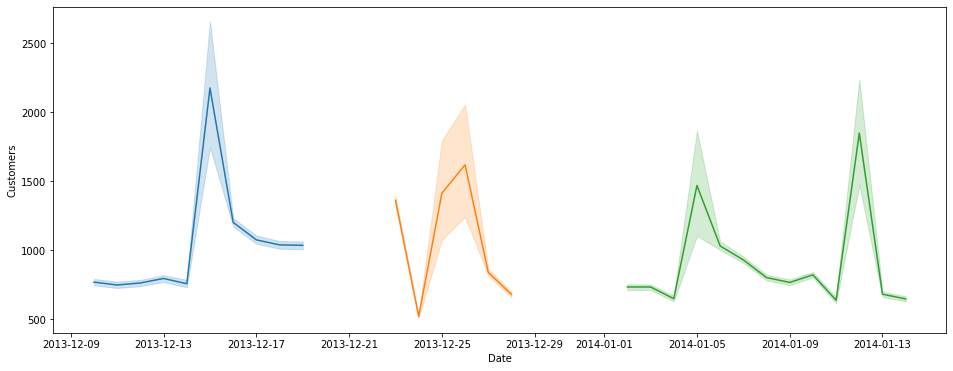

In [26]:
sns.lineplot(x = pre_holiday["Date"] , y = pre_holiday["Customers"] )
sns.lineplot(x = during_holiday["Date"] , y = during_holiday.Customers )
sns.lineplot(x = post_holiday["Date"] , y = post_holiday.Customers )

- As shown in the figure, the purchase before the holiday is high and during the holiday is relatively before the holiday it starts decrease and the day after the holiday is small.

####  What can you say about the correlation between sales and number of customers?

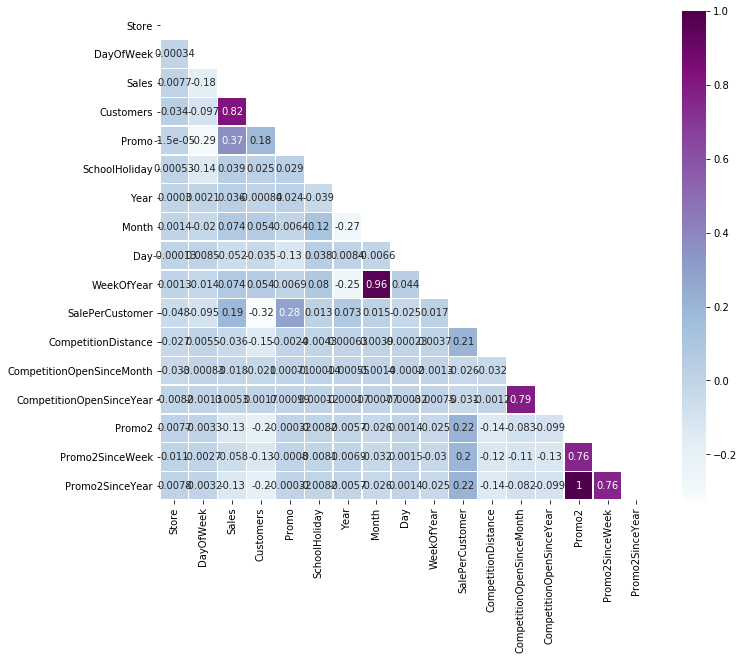

In [27]:
corr_matrix = train_store.drop('Open', axis = 1).corr()

mask = np.zeros_like(corr_matrix, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize = (11, 9))

sns.heatmap(corr_matrix,annot=True,mask=mask, linewidths=.5,ax = ax, cmap = "BuPu")


- As shown in the figure , the more purpeled square is the more related data, so which is **sales and customers**

#### How does promo affect sales? Are the promos attracting more customers? 

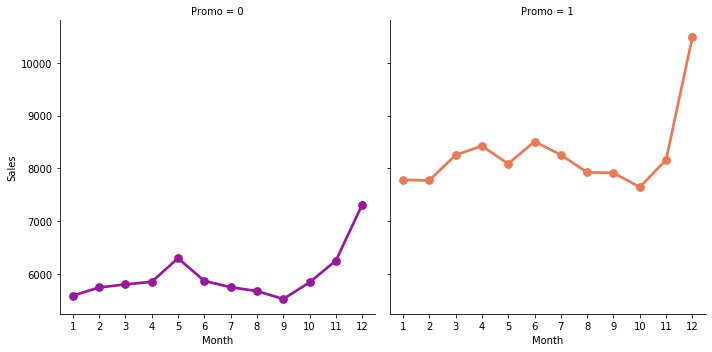

In [28]:
#promo and sales
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'Promo', # sales per promo  in cols
               palette = 'plasma',
               hue = 'Promo',
              
               color = c) 

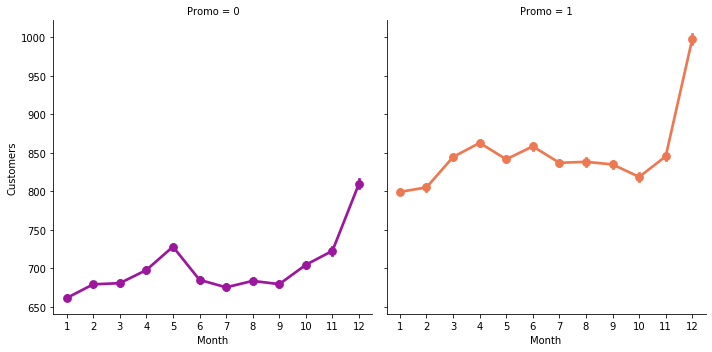

In [29]:
#promo and customers

sns.factorplot(data = train_store, x = 'Month', y = "Customers", 
               col = 'Promo', # sales per promo  in cols
               palette = 'plasma',
               hue = 'Promo',
              
               color = c) 

**Could the promos be deployed in more effective ways? Which stores should promos be deployed in?**

In [ ]:
#promo and stores


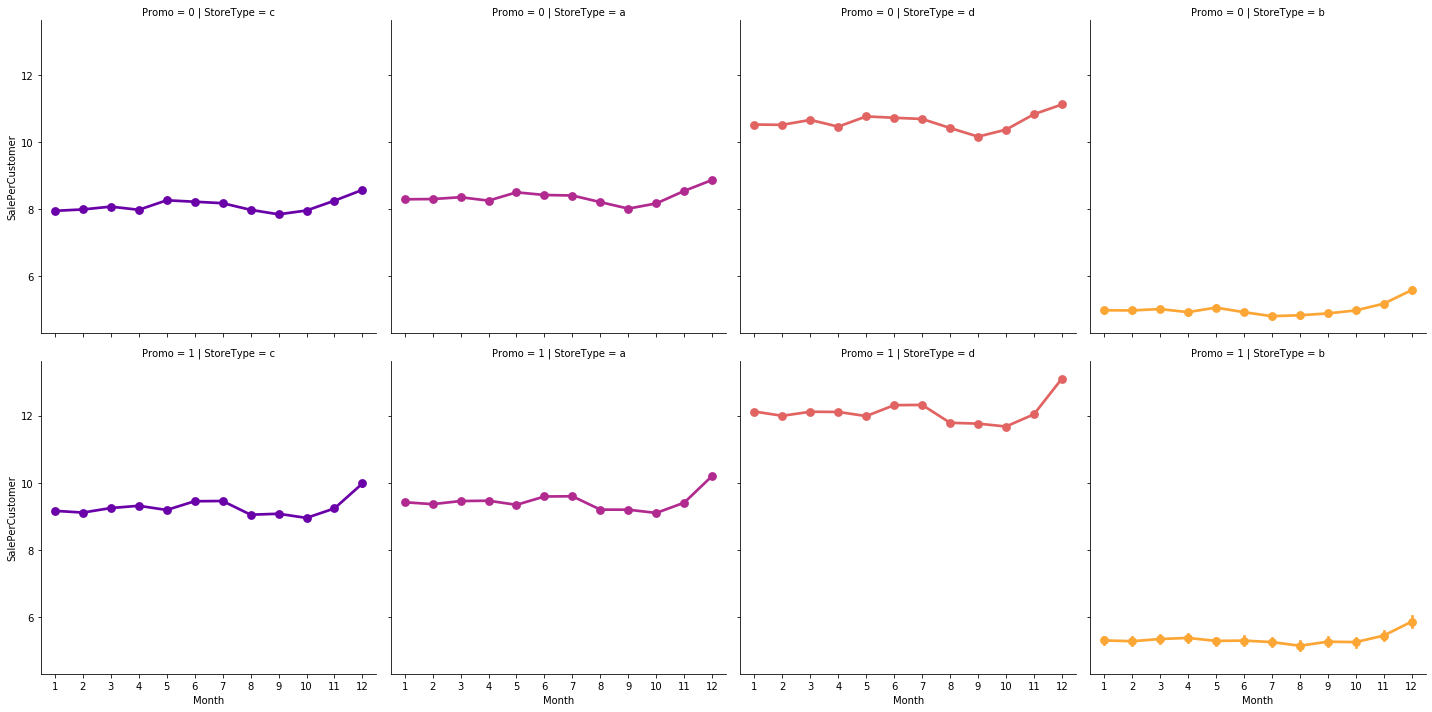

In [30]:
# sale per customer trends
sns.factorplot(data = train_store, x = 'Month', y = "SalePerCustomer", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c) 

- Low SalePerCustomer amount for StoreType B describes its Buyer Cart: there are a lot of people who shop essentially for "small" things (or in a little quantity). Plus we saw that overall this StoreType generated the least amount of sales and customers over the period

So the store type need more effective promotion, even if the number of customers increase the rate of the things they buy(sales) doesn't increase
 - they may can share the experiance of the store type D

**Trends of customer behavior during store open and closing times**

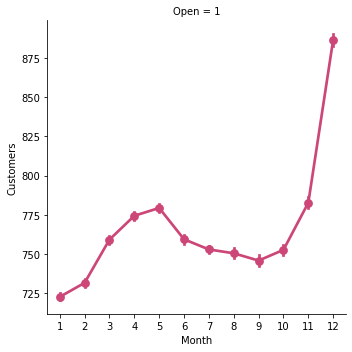

In [31]:
sns.factorplot(data = train_d, x = 'Month', y = "Customers", 
               col = 'Open', # sales per promo  in cols
               palette = 'plasma',
               hue = 'Open',
              
               color = c) 

####  Which stores are opened on all weekdays? How does that affect their sales on weekends? 

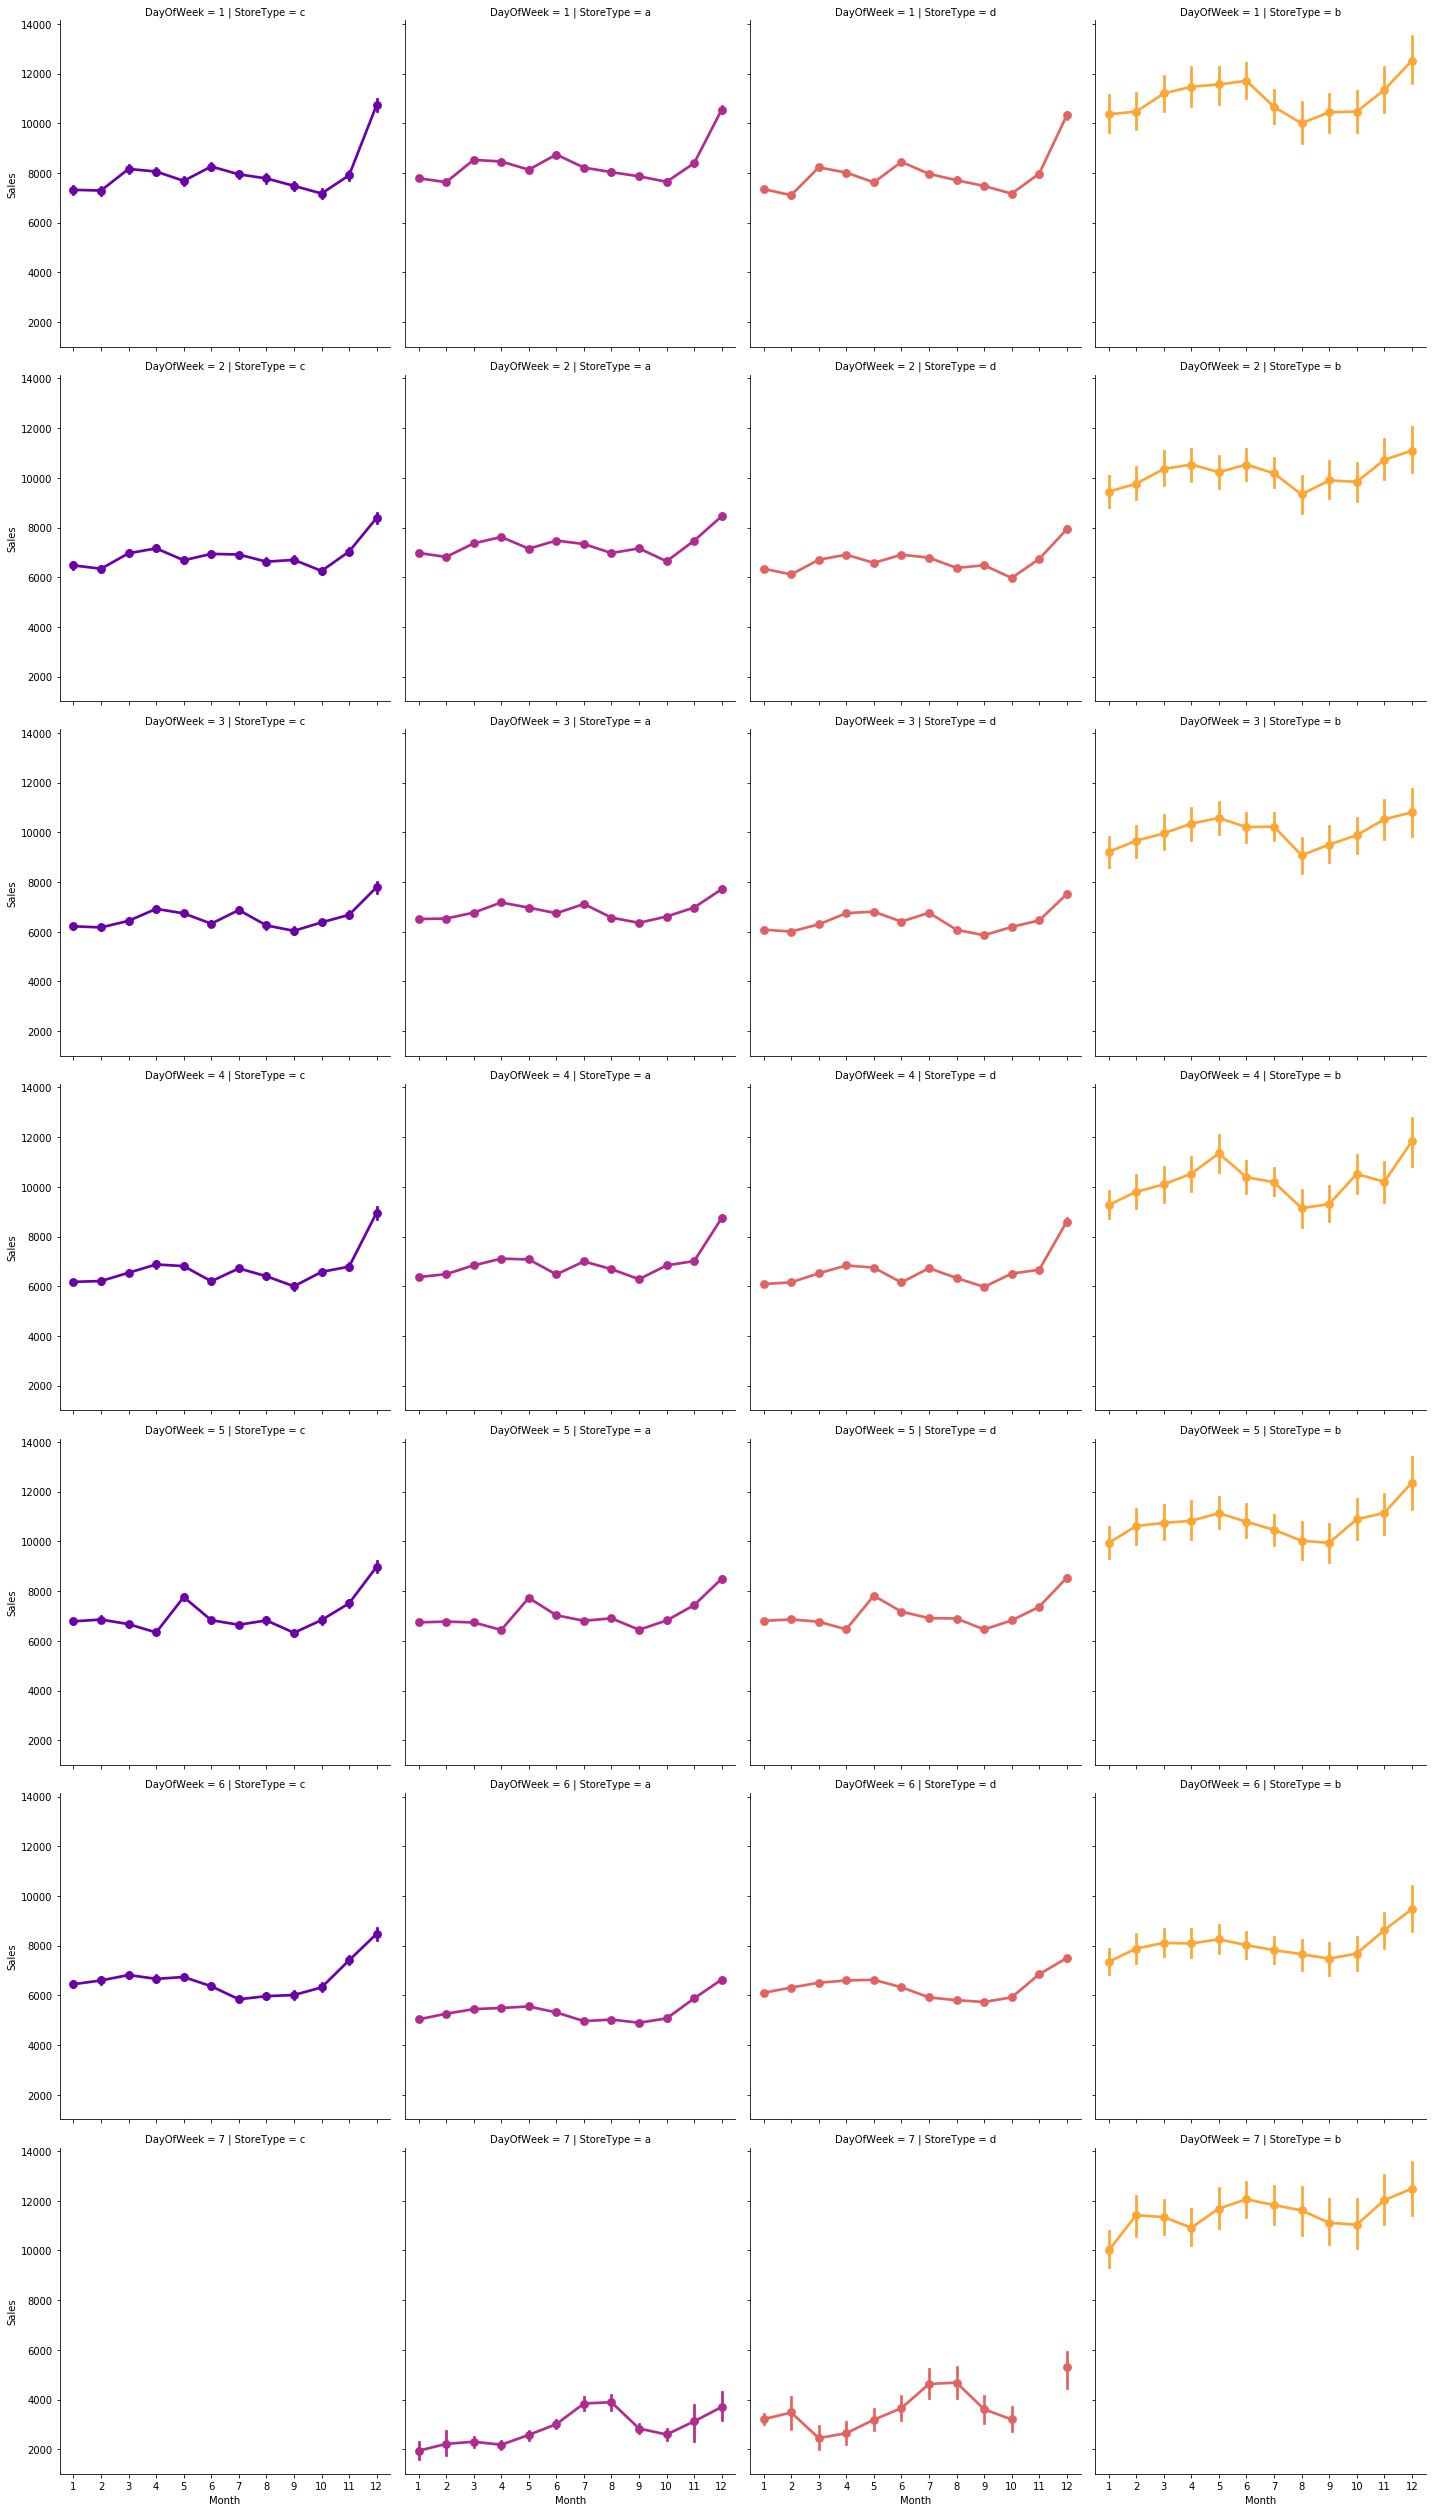

In [32]:
#customers trends
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'DayOfWeek', # per day of week in the store in rows
               color = c) 

We see that stores of StoreType C are all closed on Sundays, whereas others are most of the time opened. Interestingly enough, stores of StoreType D are closed on Sundays only from October to December.

#### Check how the assortment type affects sales 

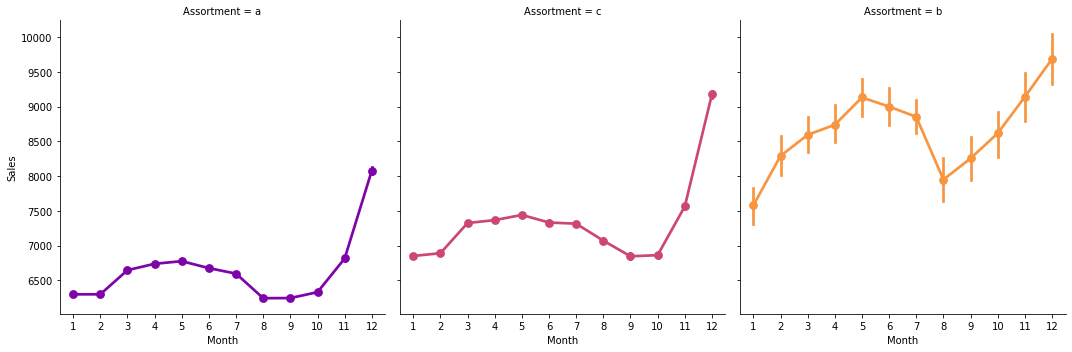

In [33]:
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'Assortment',
               palette = 'plasma',
               hue = 'Assortment',
               color = c) 

- Assortment type b has high sale, the trend that ass-b use is better than others.

**How does the distance to the next competitor affect sales? What if the store and its competitors all happen to be in city centres, does the distance matter in that case?**

In [34]:
comp_store = train_store.groupby("Store").agg({'CompetitionDistance':'max','Sales':'sum'})

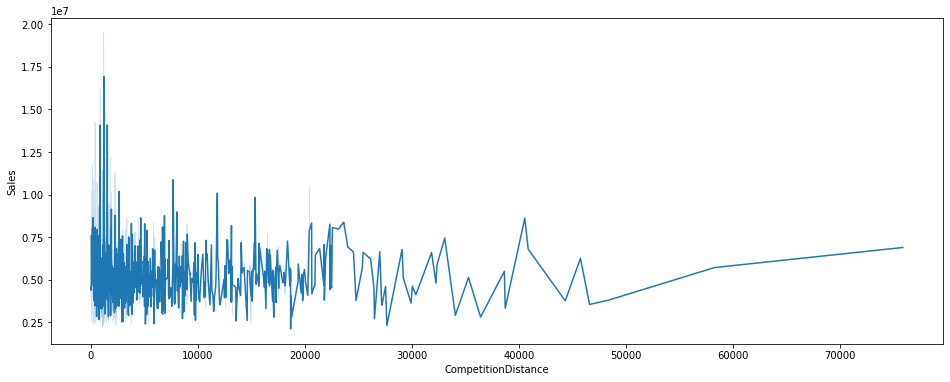

In [35]:
sns.lineplot(x = 'CompetitionDistance',y = "Sales",
             data = comp_store)

- As shown in the figure the more the store found in same place , they have more sales.
- which means, there are higher sales where other stores are found within 10km, otherwise it's usually not in city

**How does the opening or reopening of new competitors affect stores? Check for stores with NA as competitor distance but later on has values for competitor distance**

In [36]:
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)

train_store.fillna(0, inplace = True)

col = ['StoreType', 'Sales','Customers', 'CompetitionOpen']
comp_open = train_store[col]
comp_open.head()

,StoreType,Sales,Customers,CompetitionOpen
0,c,5263,555,82.0
1,c,5020,546,82.0
2,c,4782,523,82.0
3,c,5011,560,82.0
4,c,6102,612,82.0


# Task 2

Description
- Implements a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

In [7]:
df = pd.read_csv("train.csv",  
                    low_memory = False)

# remove closed stores and those with no sales
df = df[(df["Open"] != 0) & (df['Sales'] != 0)]

# sales for the store number 1 (StoreType C)
sales = df[df.Store == 1].loc[:, ['Date', 'Sales']]

# reverse to the order: from 2013 to 2015
sales = sales.sort_index(ascending = False)

# to datetime64
sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

In [8]:
# from the prophet documentation every variables should have specific names
sales = sales.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
sales.head()

,ds,y
1014980,2013-01-02,5530
1013865,2013-01-03,4327
1012750,2013-01-04,4486
1011635,2013-01-05,4997
1009405,2013-01-07,7176


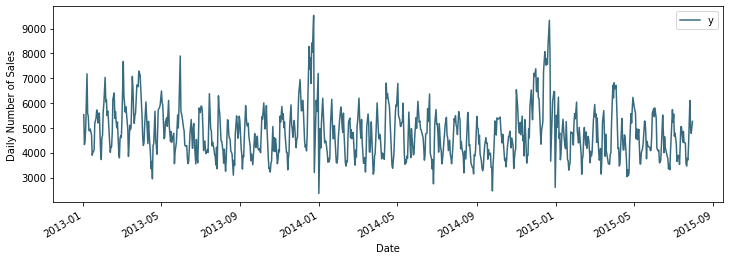

In [13]:
# plot daily sales
ax = sales.set_index('ds').plot(figsize = (12, 4), color = c)
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()


Modeling Holidays

In [14]:
# create holidays dataframe
state_dates = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & (df.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))      
holidays.head()

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04


In [18]:
# from fbprophet import prophet
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width = 0.95, 
                   holidays = holidays)
my_model.fit(sales)

# dataframe that extends into future 6 weeks 
future_dates = my_model.make_future_dataframe(periods = 6*7)

print("First week to forecast.")
future_dates.tail(7)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


First week to forecast.


,ds
816,2015-09-05
817,2015-09-06
818,2015-09-07
819,2015-09-08
820,2015-09-09
821,2015-09-10
822,2015-09-11


In [6]:
future_dates.head()

NameError: name 'future_dates' is not defined

In [24]:
# predictions
forecast = my_model.predict(future_dates)

# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
816,2015-09-05,4092.196373,2462.302849,5624.901395
817,2015-09-06,4086.982771,2396.927742,5794.885100
818,2015-09-07,4161.672877,2424.715235,5735.788821
819,2015-09-08,3664.111439,1942.299749,5187.423211
820,2015-09-09,3550.936324,1796.227830,5229.010731
821,2015-09-10,3462.430053,1743.951900,5111.161531
822,2015-09-11,3717.080395,2079.812073,5269.054179


In [25]:
fc = forecast[['ds', 'yhat']].rename(columns = {'ds': 'Date', 'yhat': 'Forecast'})

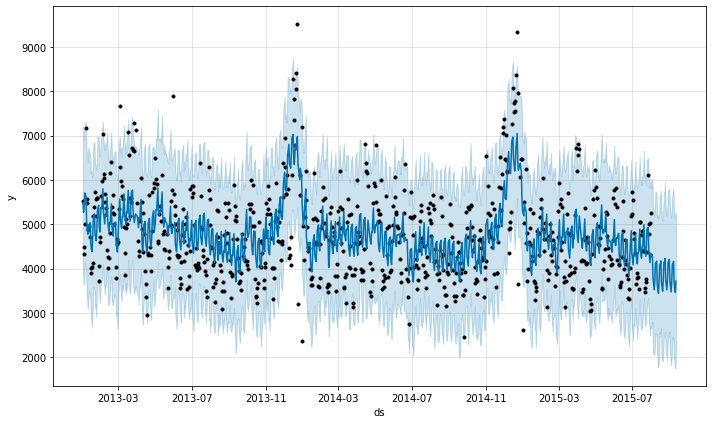

In [26]:
# visualizing predicions
my_model.plot(forecast);

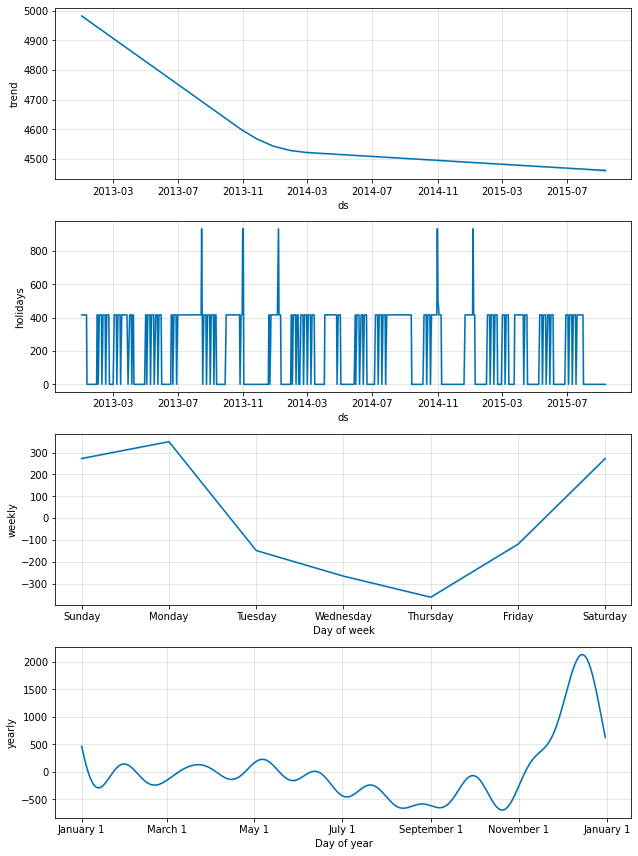

In [27]:
my_model.plot_components(forecast);

In [29]:
import pickle
import datetime
# get the current time and turn it into a string
now = datetime.datetime.now().strftime('%d-%m-%Y-%H-%M-%S-%f')[:-3]
# Saving model to disk
filename = now + '.pkl'
pickle.dump(my_model, open(filename, 'wb'))


In [30]:
model = pickle.load(open(filename,'rb')) 

In [32]:
model.predict(future_dates)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-02,4982.921384,3945.898996,7077.812683,4982.921384,4982.921384,497.320707,497.320707,497.320707,416.332513,...,-265.738912,-265.738912,-265.738912,346.727106,346.727106,346.727106,0.0,0.0,0.0,5480.242091
1,2013-01-03,4981.638949,3684.431001,6921.329382,4981.638949,4981.638949,288.912753,288.912753,288.912753,416.332513,...,-362.076125,-362.076125,-362.076125,234.656365,234.656365,234.656365,0.0,0.0,0.0,5270.551702
2,2013-01-04,4980.356514,3769.848611,7154.088914,4980.356514,4980.356514,428.816846,428.816846,428.816846,416.332513,...,-119.299017,-119.299017,-119.299017,131.783349,131.783349,131.783349,0.0,0.0,0.0,5409.173360
3,2013-01-05,4979.074080,4129.491774,7279.376585,4979.074080,4979.074080,728.638741,728.638741,728.638741,416.332513,...,273.186599,273.186599,273.186599,39.119630,39.119630,39.119630,0.0,0.0,0.0,5707.712821
4,2013-01-07,4976.509210,4036.094380,7374.473547,4976.509210,4976.509210,653.390197,653.390197,653.390197,416.332513,...,349.711853,349.711853,349.711853,-112.654169,-112.654169,-112.654169,0.0,0.0,0.0,5629.899407
5,2013-01-08,4975.226776,3420.396766,6766.549316,4975.226776,4975.226776,96.941281,96.941281,96.941281,416.332513,...,-148.504440,-148.504440,-148.504440,-170.886792,-170.886792,-170.886792,0.0,0.0,0.0,5072.168057
6,2013-01-09,4973.944341,3314.395672,6565.564272,4973.944341,4973.944341,-66.565822,-66.565822,-66.565822,416.332513,...,-265.738912,-265.738912,-265.738912,-217.159424,-217.159424,-217.159424,0.0,0.0,0.0,4907.378519
7,2013-01-10,4972.661906,3149.007852,6352.089900,4972.661906,4972.661906,-197.362565,-197.362565,-197.362565,416.332513,...,-362.076125,-362.076125,-362.076125,-251.618952,-251.618952,-251.618952,0.0,0.0,0.0,4775.299342
8,2013-01-11,4971.379472,3405.190368,6703.485978,4971.379472,4971.379472,22.401441,22.401441,22.401441,416.332513,...,-119.299017,-119.299017,-119.299017,-274.632056,-274.632056,-274.632056,0.0,0.0,0.0,4993.780912
9,2013-01-12,4970.097037,3352.673447,6530.529616,4970.097037,4970.097037,-13.583139,-13.583139,-13.583139,0.000000,...,273.186599,273.186599,273.186599,-286.769738,-286.769738,-286.769738,0.0,0.0,0.0,4956.513898


# Random forest

Why use **Random Forest** Algorithm in machine learning.

- Random forest algorithm can be used for both classifications and regression task.
- It provides higher accuracy.
- Random forest classifier will handle the missing values and maintain the accuracy of a large proportion of data.
- If there are more trees, it won’t allow overfitting trees in the model.
- It has the power to handle a large data set with higher dimensionality

- **Stock Market:** Machine learning also plays role in the stock market analysis. When you want to know the behavior of the stock market, with the help of Random forest algorithm, the behavior of the stock market can be analyzed. Also, it can show the expected loss or profit which can be produced while purchasing a particular stock.

In [21]:
# load and preview dataset
store = pd.read_csv('store.csv')
store.sample(3)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
734,735,d,c,1920.0,4.0,2005.0,0,NaN,NaN,NaN
641,642,c,c,530.0,4.0,2005.0,1,35.0,2010.0,"Mar,Jun,Sept,Dec"
179,180,d,a,5800.0,9.0,2010.0,0,NaN,NaN,NaN


In [22]:
# load and preview dataset
train = pd.read_csv('train.csv')
train.sample(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
2951,722,3,2015-07-29,8348,1251,1,1,0,1
361700,35,2,2014-08-19,12696,918,1,1,0,1
958636,522,5,2013-02-22,8463,624,1,1,0,0


In [23]:
# load and preview dataset
test = pd.read_csv('test.csv')
test.sample(3)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
24373,24374,529,4,2015-08-20,1.0,1,0,1
19278,19279,577,3,2015-08-26,1.0,0,0,1
37175,37176,481,3,2015-08-05,1.0,1,0,1


In [5]:
def preprocess(data):
  
    data['Date'] = pd.to_datetime(data['Date'],format = '%Y-%m-%d')
    data['day']=data['Date'].dt.day
    data['month']=data['Date'].dt.month
    data['year']=data['Date'].dt.year
    data['WeekOfYear'] = data['Date'].dt.weekofyear
    data['SalePerCustomer'] = data['Sales']/data['Customers']


  df_train_store=pd.merge(store,data,how='left',on='Store')


  map_promo= {'Jan,Apr,Jul,Oct':1,'Feb,May,Aug,Nov':2,'Mar,Jun,Sept,Dec':3}
  df_train_store['PromoInterval']=df_train_store['PromoInterval'].map(map_promo)

  df_train_store['StateHoliday'].replace({0:'o','0':'o'},inplace=True)
  df_train_store['StateHoliday'].replace({'0':'o'},inplace=True)

  df_train_store = df_train_store[(df_train_store["Open"] != 0) & (df_train_store["Sales"] != 0)]

  df_train_store=df_train_store.drop(['Date','Open','Store'],axis=1)

  return df_train_store

In [6]:
df_train_store=preprocess(train)

In [7]:
X=df_train_store.drop(['Sales'],axis=1)
y=np.log1p(df_train_store.Sales)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [9]:

##SKLEARN MODEL PIPELINE


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

##Function to preprocess the data

num_pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                    #('drop_attributes', AttributeDeleter()),
                                    #('std_scaler', StandardScaler())
                            ])
categorical_pipeline=Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

categorical_features = df_train_store.select_dtypes(include=['object']).columns
numerical_features = df_train_store.select_dtypes(include=['float64', 'int64']).drop(['Sales'],axis=1).columns

full_pipeline = ColumnTransformer(
        transformers=[('num', num_pipeline, numerical_features),
                     ('cat', categorical_pipeline, categorical_features)])

    

In [10]:
from sklearn.ensemble import RandomForestRegressor
rf = Pipeline(steps=[('preprocessor', full_pipeline),
                      ('regressor', RandomForestRegressor())])

In [ ]:

rf.fit(X_train, y_train)

In [ ]:
y_pred = rf.predict(X_test)


In [ ]:
## Score of our model

from sklearn.metrics import r2_score, mean_squared_error


r2_score(y_test,y_pred)

In [ ]:
## Calculating the MSE
mean_squared_error(y_test,y_pred)

In [ ]:
## Calculating the loss
np.sqrt(mean_squared_error(y_test,y_pred))